In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# read csv
df = pd.read_csv('unfiltered_gwq.csv')
# include only state,< district, year
df = df[['state', 'district', 'year', 'chloride']]
# drop duplicates
df = df.drop_duplicates()
# drop rows with missing values
df = df.dropna()
# change indexing
df = df.reset_index(drop=True)
# save df as filtered_gwq.csv
df.to_csv('filtered_gwq.csv', index=False)

In [ ]:
df = pd.read_csv('filtered_gwq.csv')
# for filtered_gwq.csv, remove data if state (telangana or andhra pradesh) and year is <= 2004
df = df[~((df['state'] == 'Telangana') & (df['year'] < 2004))]
df = df[~((df['state'] == 'Andhra Pradesh') & (df['year'] < 2004))]
# change indexing
df = df.reset_index(drop=True)
# save df as filtered_gwq.csv
df.to_csv('filtered_gwq.csv', index=False)

In [ ]:
# read filtered_gwq.csv and draw histogram for state-wise avg chloride concentration
df = pd.read_csv('filtered_gwq.csv')
df = df.groupby('state').mean()
df = df.reset_index()
# print(df)

# sort by concentration
df = df.sort_values('chloride')
df.plot(x='state', y='chloride', kind='bar')
plt.show()

In [ ]:
# print number of datapoints vs state
df = pd.read_csv('filtered_gwq.csv')
df = df.groupby('state').count()
df = df.reset_index()
df = df[['state', 'district']]
df.columns = ['state', 'datapoints']
df = df.sort_values('datapoints')
# print(df)
df.plot(x='state', y='datapoints', kind='bar')
plt.show()

In [ ]:
df = pd.read_csv('filtered_gwq.csv')
# Store names of all states
states = df['state'].unique()
# Create a new dataframe to store missing counts (integer)
incomplete_data = pd.DataFrame(columns=['state', 'missing', 'expected', 'missing_ratio'])
# Calculate missing data for each state
for state in states:
    districts = df[df['state'] == state]['district'].unique()
    available = df[df['state'] == state]
    missing_count = 19 * len(districts) - len(available)
    expected_count = 19 * len(districts)
    missing_ratio = 1 - (len(available) / expected_count)
    incomplete_data = pd.concat([incomplete_data, pd.DataFrame({'state': [state], 'missing': [missing_count], 'expected': [expected_count], 'missing_ratio': [missing_ratio]})], ignore_index=True)
incomplete_data = incomplete_data.sort_values('missing_ratio')
incomplete_data.plot(x='state', y='missing_ratio', kind='bar')
# Print states with missing ratio greater than 0.7
print(incomplete_data[incomplete_data['missing_ratio'] > 0.7])

In [ ]:
df1 = pd.read_csv('unfiltered_sdp1.csv')
df2 = pd.read_csv('unfiltered_sdp2.csv')
df3 = pd.read_csv('unfiltered_sdp3.csv')
states = df1.keys()[1:]
df_sdp = pd.DataFrame(columns = df1.keys())
for state in states:
    df1_state = df1[state]
    df2_state = df2[state]
    df3_state = df3[state]
    # scaling factor 1 is df3_state's first value / df2_state's last value
    scaling_factor1 = df3_state.iloc[0] / df2_state.iloc[-1]
    # change df2_state values by scaling factor 1
    df2_state = df2_state * scaling_factor1
    # scaling factor 2 is df2_state's first value / df1_state's last value
    scaling_factor2 = df2_state.iloc[0] / df1_state.iloc[-1]
    # change df1_state values by scaling factor 2
    df1_state = df1_state * scaling_factor2
    
    # remove first and last elements of df2_state
    df2_state = df2_state[1:-1]
    df_sdp[state] = pd.concat([df1_state, df2_state, df3_state], ignore_index=True)
    print(state, scaling_factor1)
# df_sdp make years as 1999, 2000, and so on
df_sdp['YEAR'] = range(1999, 2019)
df_sdp.to_csv('filtered_sdp.csv', index=False)


In [ ]:
# add sdp for every data in gwq
df_gwq = pd.read_csv('filtered_gwq.csv')
df_sdp = pd.read_csv('filtered_sdp.csv')
n_samples = len(df_gwq)
# for every data in gwq, find the corresponding sdp value
for i in range(n_samples):
    state = df_gwq['state'][i]
    year = df_gwq['year'][i]
    state = state.upper()
    try:
        sdp = df_sdp[state][year - 1999]
        df_gwq.loc[i, 'sdp'] = sdp
    except:
        # print(state)
        # remove data
        df_gwq = df_gwq.drop(i)
# sort by state
df_gwq.dropna()
df_gwq = df_gwq.sort_values('state')
df_gwq.to_csv('filtered_gwq_sdp.csv', index=False)

In [ ]:
# i indexes districts, t indexes years, and ui,t is random error.
# GWQi,t = β0 + β1SDPi,t + ui,t
df_gwq = pd.read_csv('filtered_gwq_sdp.csv')
y_mean = df_gwq['chloride'].mean()
# print(y_mean)
# calculate x_mean
x_mean = df_gwq['sdp'].mean()
# print(x_mean)
# calculate sum(xi-x_mean)(yi-y_mean) / sum(xi-x_mean)^2
beta1 = 0
beta2 = 0
n_samples = len(df_gwq)
for i in range(n_samples):
    beta1 += (df_gwq['sdp'][i] - x_mean) * (df_gwq['chloride'][i] - y_mean)
    beta2 += (df_gwq['sdp'][i] - x_mean) ** 2
beta1 = beta1 / beta2
print(beta1)
# calculate beta0
beta0 = y_mean - beta1 * x_mean
print(beta0)
# summarize the results in a table and interpret
# print(df_gwq)
df_gwq['predicted_chloride'] = beta0 + beta1 * df_gwq['sdp']
df_gwq['error'] = df_gwq['chloride'] - df_gwq['predicted_chloride']
df_gwq.to_csv('filtered_gwq_sdp_predicted.csv', index=False)
# calculate R^2
ssr = 0
sst = 0
for i in range(n_samples):
    ssr += (df_gwq['predicted_chloride'][i] - y_mean) ** 2
    sst += (df_gwq['chloride'][i] - y_mean) ** 2
r_squared = ssr / sst
print(r_squared)

In [118]:
# gwq = beta0 + beta1 * sdp + ui
X = df_gwq['sdp']
X = sm.add_constant(X)
y = df_gwq['chloride']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())
r_squared = model.rsquared
print("R-squared:", r_squared)
# print estimators 
print("Estimated coefficients:")
print("Beta0:", beta0)
print("Beta1:", beta1)

                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     119.0
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           1.69e-27
Time:                        18:02:00   Log-Likelihood:                -49689.
No. Observations:                7530   AIC:                         9.938e+04
Df Residuals:                    7528   BIC:                         9.940e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        149.3060      3.296     45.294      0.0

In [ ]:
# plot graph for all states sdp vs year to verify sdp estimations from filtered_sdp.csv
df_sdp = pd.read_csv('filtered_sdp.csv')
states = df_sdp.keys()[1:]
# print(states)
for state in states:
    df_sdp.plot(x='YEAR', y=state)
    plt.show()

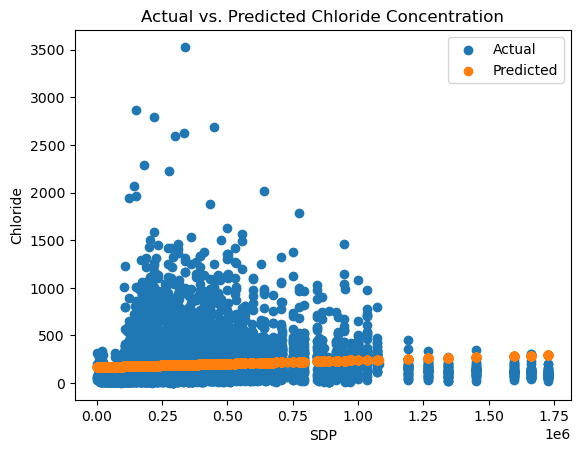

In [119]:
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted.csv')
# Plot 1: Groundwater quality indicator (chloride) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')
plt.legend()

In [ ]:
# Plot 2: Residuals (ûi,t) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['error'])
plt.xlabel('SDP')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [ ]:
# Plot a histogram of ûi,t and verify that ∑û = 0.
plt.hist(df_gwq['error'])
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()
# verify that ∑û = 0
print(df_gwq['error'].sum())

                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     227.0
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           1.68e-96
Time:                        18:02:20   Log-Likelihood:                -52265.
No. Observations:                7640   AIC:                         1.045e+05
Df Residuals:                    7637   BIC:                         1.046e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.048e-09   1.27e-10     47.459      

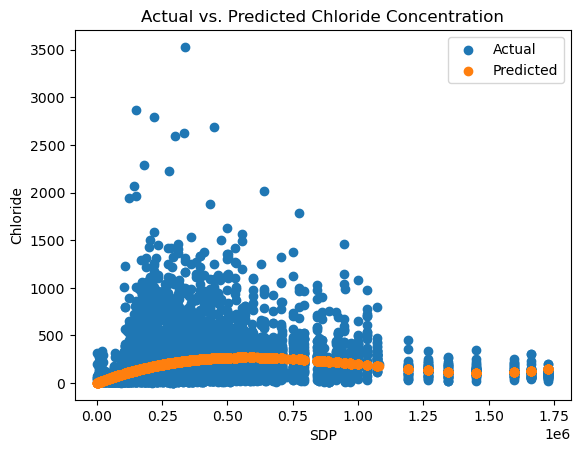

In [120]:
# kuznets without gini
# gwq = b0 + b1sdp + b2sdp^2 + b3sdp^3 + ui,t
df_gwq = pd.read_csv('filtered_gwq_sdp.csv')
# Define the independent variable (predictor) and dependent variable
X = df_gwq['sdp']
Y = df_gwq['chloride']
# Add a constant to the independent variable for the intercept term
X = sm.add_constant(X)
# Create additional columns for the squared and cubed terms of the predictor
X['sdp_squared'] = X['sdp'] ** 2
X['sdp_cubed'] = X['sdp'] ** 3
# Fit the cubic regression model
model = sm.OLS(Y, X).fit()
# Print the summary of the regression results
print(model.summary())
# Get the estimated coefficients
beta0 = model.params['const']
beta1 = model.params['sdp']
beta2 = model.params['sdp_squared']
beta3 = model.params['sdp_cubed']
# Predicted values
df_gwq['predicted_chloride'] = beta0 + beta1 * df_gwq['sdp'] + beta2 * (df_gwq['sdp'] ** 2) + beta3 * (df_gwq['sdp'] ** 3)
# Calculate residuals
df_gwq['error'] = df_gwq['chloride'] - df_gwq['predicted_chloride']
# Calculate R-squared
r_squared = model.rsquared
print("R-squared:", r_squared)
# print estimators 
print("Estimated coefficients:")
print("Beta0:", beta0)
print("Beta1:", beta1)
print("Beta2:", beta2)
print("Beta3:", beta3)
# Save the results to a CSV file
df_gwq.to_csv('filtered_gwq_sdp_predicted_cubic.csv', index=False)
# plot filtered_gwq_sdp_predicted_cubic.csv
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted_cubic.csv')
# Plot 1: Groundwater quality indicator (chloride) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     191.6
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           6.34e-82
Time:                        18:02:26   Log-Likelihood:                -52298.
No. Observations:                7640   AIC:                         1.046e+05
Df Residuals:                    7637   BIC:                         1.046e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.9669      6.290     13.350      

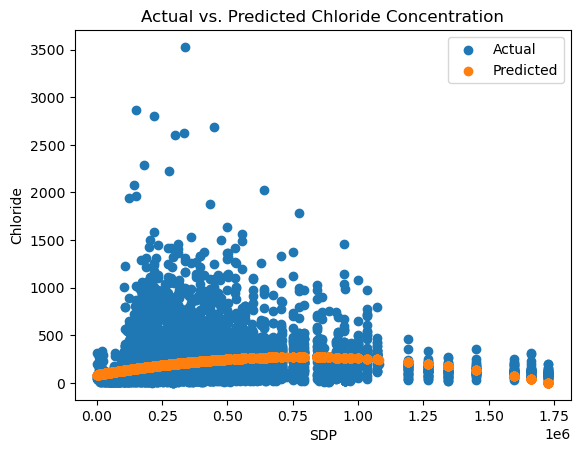

In [121]:
# kuznets without gini
# gwq = b0 + b1sdp + b2sdp^2 + ui,t
df_gwq = pd.read_csv('filtered_gwq_sdp.csv')
# Define the independent variable (predictor) and dependent variable
X = df_gwq['sdp']
Y = df_gwq['chloride']
# Add a constant to the independent variable for the intercept term
X = sm.add_constant(X)
# Create an additional column for the squared term of the predictor
X['sdp_squared'] = X['sdp'] ** 2
# Fit the quadratic regression model
model = sm.OLS(Y, X).fit()
# Print the summary of the regression results
print(model.summary())
# Get the estimated coefficients
beta0 = model.params['const']
beta1 = model.params['sdp']
beta2 = model.params['sdp_squared']
# Predicted values
df_gwq['predicted_chloride'] = beta0 + beta1 * df_gwq['sdp'] + beta2 * (df_gwq['sdp'] ** 2)
# Calculate residuals
df_gwq['error'] = df_gwq['chloride'] - df_gwq['predicted_chloride']
# Calculate R-squared
r_squared = model.rsquared
print("R-squared:", r_squared)
# print estimators
print("Estimated coefficients:")
print("Beta0:", beta0)
print("Beta1:", beta1)
print("Beta2:", beta2)
# Save the results to a CSV file
df_gwq.to_csv('filtered_gwq_sdp_predicted_quadratic.csv', index=False)
# plot filtered_gwq_sdp_predicted_quadratic.csv
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted_quadratic.csv')
# Plot 1: Groundwater quality indicator (chloride) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:               chloride   R-squared:                      -0.039
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    -142.2
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               1.00
Time:                        18:02:32   Log-Likelihood:                -52630.
No. Observations:                7640   AIC:                         1.053e+05
Df Residuals:                    7637   BIC:                         1.053e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          3.6e-20   6.61e-22     54.484      

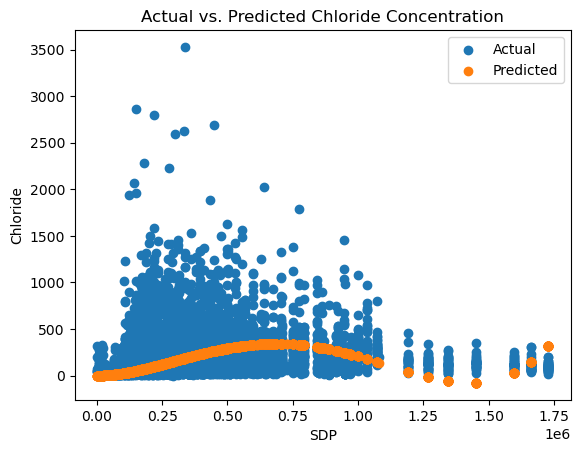

In [122]:
# kuznets without gini
# gwq = b0 + b1sdp + b2sdp^2 + b3sdp^3 + b4sdp^4 ui,t
df_gwq = pd.read_csv('filtered_gwq_sdp.csv')
# Define the independent variable (predictor) and dependent variable
X = df_gwq['sdp']
Y = df_gwq['chloride']
# Add a constant to the independent variable for the intercept term
X = sm.add_constant(X)
# Create an additional column for the squared term of the predictor
X['sdp_squared'] = X['sdp'] ** 2
X['sdp_cubed'] = X['sdp'] ** 3
X['sdp_fourth'] = X['sdp'] ** 4
# Fit the quadratic regression model
model = sm.OLS(Y, X).fit()
# Print the summary of the regression results
print(model.summary())
# Get the estimated coefficients
beta0 = model.params['const']
beta1 = model.params['sdp']
beta2 = model.params['sdp_squared']
beta3 = model.params['sdp_cubed']
beta4 = model.params['sdp_fourth']
# Predicted values
df_gwq['predicted_chloride'] = beta0 + beta1 * df_gwq['sdp'] + beta2 * (df_gwq['sdp'] ** 2) + beta3 * (df_gwq['sdp'] ** 3) + beta4 * (df_gwq['sdp'] ** 4)
# Calculate residuals
df_gwq['error'] = df_gwq['chloride'] - df_gwq['predicted_chloride']
# Calculate R-squared
r_squared = model.rsquared
print("R-squared:", r_squared)
# print estimators
print("Estimated coefficients:")
print("Beta0:", beta0)
print("Beta1:", beta1)
print("Beta2:", beta2)
print("Beta3:", beta3)
print("Beta4:", beta4)
# Save the results to a CSV file
df_gwq.to_csv('filtered_gwq_sdp_predicted_quadratic.csv', index=False)
# plot filtered_gwq_sdp_predicted_quadratic.csv
df_gwq = pd.read_csv('filtered_gwq_sdp_predicted_quadratic.csv')
# Plot 1: Groundwater quality indicator (chloride) on Y-axis and SDP on X-axis
plt.scatter(df_gwq['sdp'], df_gwq['chloride'], label='Actual')
plt.scatter(df_gwq['sdp'], df_gwq['predicted_chloride'], label='Predicted')
plt.xlabel('SDP')
plt.ylabel('Chloride')
plt.title('Actual vs. Predicted Chloride Concentration')
plt.legend()
plt.show()

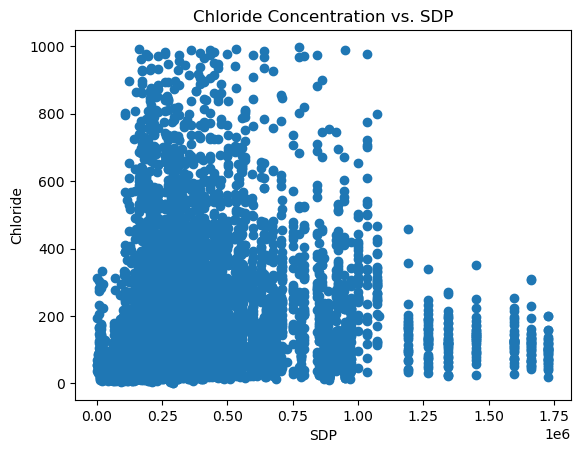

In [117]:
# handle outliers
df_gwq = pd.read_csv('filtered_gwq_sdp.csv')
# remove outliers 